<a href="https://colab.research.google.com/github/andrewmao33/soccer-player-price-forcaster/blob/main/prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xg
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

## Methods

In [ ]:
def draw_scatterplot(test_y, pred):
  plt.figure(figsize=(10,10))
  plt.scatter(test_y, pred, c='crimson')
  plt.yscale('log')
  plt.xscale('log')

  p1 = max(max(test_y), max(pred))
  p2 = min(min(test_y), min(pred))
  plt.plot([p1, p2], [p1, p2], 'b-')
  plt.xlabel('True Values', fontsize=15)
  plt.ylabel('Predictions', fontsize=15)
  plt.axis('equal')
  plt.show()

def draw_differences(test_y, pred):
  plt.figure(figsize=(5, 7))

  ax = sns.distplot(test_y, hist=False, color="r", label="Actual Value")
  sns.distplot(pred, hist=False, color="b", label="Fitted Values" , ax=ax)
  plt.legend(loc="upper right")
  plt.title('Actual vs Fitted Values for Market Value')

  plt.show()
  plt.close()

## Get Data

In [ ]:
df = pd.read_csv('fulldata_final.csv')
df = pd.get_dummies(df, columns=['Position'])

In [ ]:
print(df.head(5))

   121  123  231  213  212  1234  1213  1232  2134  2132  ...  \
0    1   67   68   82    6    32    18    11    59     6  ...   
1    1   70   25   41    4    28    18     6    17     3  ...   
2    1   30   56   35    8    19     0     1    14     0  ...   
3    1   55   39   42    8    24    10     6    29     2  ...   
4    1   37   32   28   10     9     6     4     6     3  ...   

   Position_Goalkeeper  Position_attack - Centre-Forward  \
0                    0                                 0   
1                    0                                 0   
2                    0                                 0   
3                    0                                 0   
4                    0                                 0   

   Position_attack - Left Winger  Position_attack - Right Winger  \
0                              0                               0   
1                              0                               0   
2                              0            

In [ ]:
df.shape

(1598, 54)

In [ ]:
df_full = df
df_noshots = df.drop(columns=['121S', '123S', '231S', '213S', '212S', '1234S', '1213S', '1232S', '2134S', '2132S', '1212S', '2313S', '2312S', '12S', '21S', '23S'])
df_stats = df[['Age', 'MP', 'Goals', 'Assists', 'xGp90', 'xAp90', 'ChCr', 'YC', 'RC', 'Tackles', 'Pressures', 'Value']]

## PCA

In [ ]:
features = ['121', '123', '231', '212', '1234', '1213', '1232', '2134', '2132', '1212', '2313', '2312']
x = df.loc[:, features].values
y = df.loc[:,['Value']].values
x = StandardScaler().fit_transform(x)
pca = PCA(n_components=5)
principalComponents = pca.fit_transform(x)
principalDf1 = pd.DataFrame(data = principalComponents)

In [ ]:
features2 = ['121S', '123S', '231S', '213S', '212S', '1234S', '1213S', '1232S', '2134S', '2132S', '1212S', '2313S', '2312S', '12S', '21S', '23S']
x2 = df.loc[:, features2].values
y2 = df.loc[:,['Value']].values
x2 = StandardScaler().fit_transform(x2)
pca = PCA(n_components=8)
principalComponents = pca.fit_transform(x2)
principalDf2 = pd.DataFrame(data = principalComponents)

In [ ]:
features3 = ['121', '123', '231', '212', '1234', '1213', '1232', '2134', '2132', '1212', '2313', '2312',
            '121S', '123S', '231S', '213S', '212S', '1234S', '1213S', '1232S', '2134S', '2132S', '1212S', '2313S', '2312S', '12S', '21S', '23S']
x3 = df.loc[:, features3].values
y3 = df.loc[:,['Value']].values
x3 = StandardScaler().fit_transform(x3)
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x3)
principalDf3 = pd.DataFrame(data = principalComponents)

In [ ]:
df_pca1 = pd.concat([principalDf1, df_stats], axis = 1)
df_pca2 = pd.concat([principalDf1, principalDf2, df_stats], axis = 1)
df_pca3 = pd.concat([principalDf3, df_stats], axis = 1)

## Explore Data


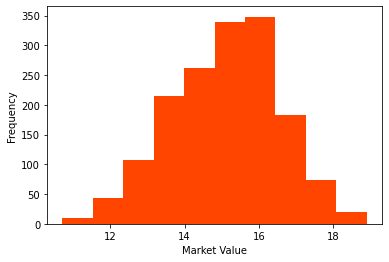

In [ ]:
plt.xlabel('Market Value')
plt.ylabel('Frequency')
plt.hist(np.log(df['Value']), color = "orangered")
plt.show()

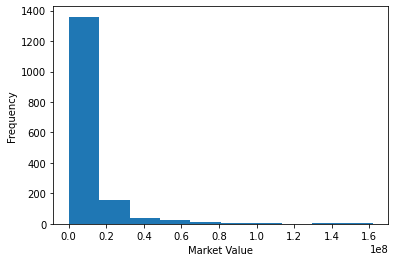

In [ ]:
plt.hist(df['Value'])
plt.xlabel('Market Value')
plt.ylabel('Frequency')
plt.show()

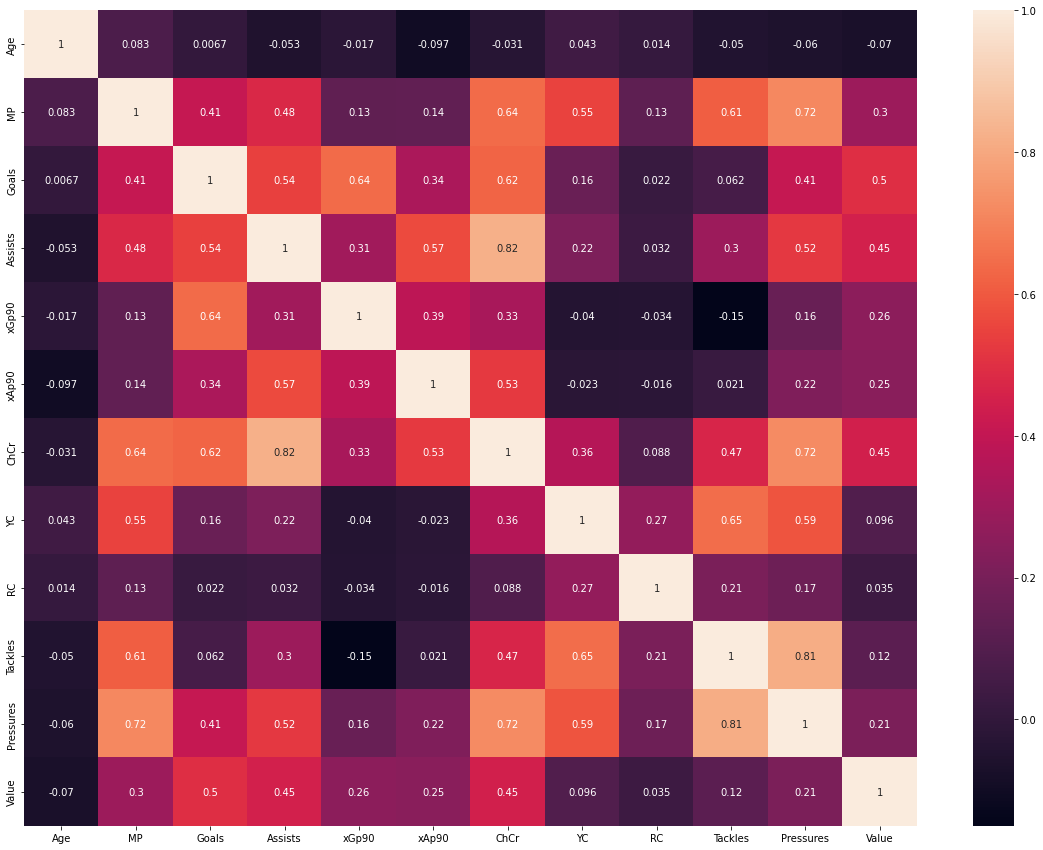

Goals      0.495472
Assists    0.450633
ChCr       0.447085
Value      1.000000
Name: Value, dtype: float64

In [ ]:
fig, ax = plt.subplots(figsize=(20,15))
corr_df = pd.DataFrame(df, columns=['Age', 'MP', 'Goals', 'Assists', 'xGp90', 'xAp90', 'ChCr', 'YC', 'RC', 'Tackles', 'Pressures', 'Value'])

corrMatrix = corr_df.corr()
sns.heatmap(corrMatrix, annot=True)
plt.show()

cor_target = abs(corrMatrix["Value"])
#Selecting highly correlated features
relevant_features = cor_target[cor_target>0.3]
relevant_features

## Build Regression Models

## Random Forest

In [ ]:
#full data
df = df_full
y = np.log(df['Value'])
#y = df['Value']

X = df.drop(columns='Value')
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=100)

rf = RandomForestRegressor()
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
mean_squared_error(y_test, y_pred)

1.32218500653248

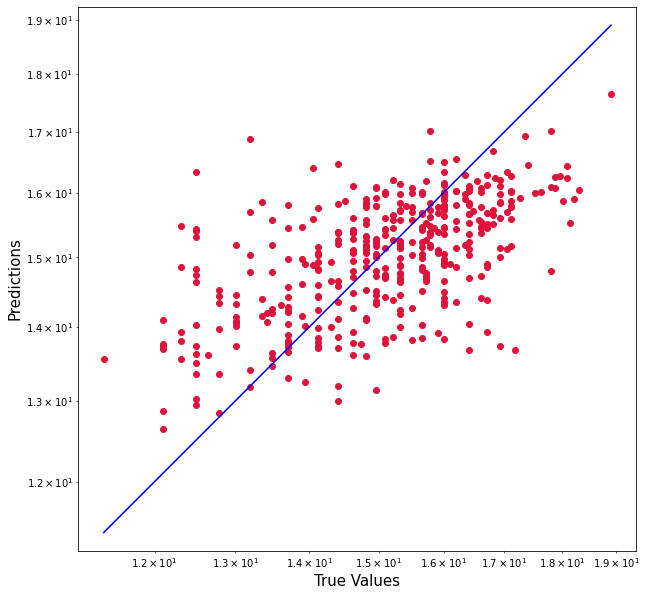

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


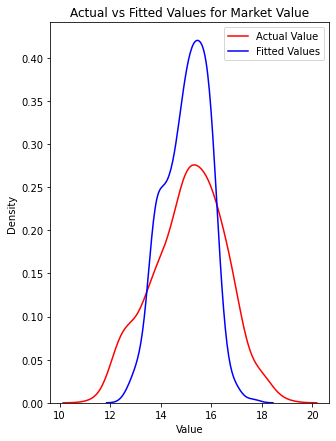

In [ ]:
draw_scatterplot(y_test, y_pred)
draw_differences(y_test, y_pred)

In [ ]:
#no shot data
df=df_noshots
y = np.log(df['Value'])
X = df.drop(columns='Value')
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=100)

rf = RandomForestRegressor()
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
mean_squared_error(y_test, y_pred)

1.327008346853654

In [ ]:
#only season stats
df=df_stats
y = np.log(df['Value'])
X = df.drop(columns='Value')
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=100)

rf = RandomForestRegressor()
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
mean_squared_error(y_test, y_pred)

1.454566377795678

In [ ]:
df=df_pca1
y = np.log(df['Value'])
X = df.drop(columns='Value')
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=100)

rf = RandomForestRegressor()
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
mean_squared_error(y_test, y_pred)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


1.3369334468065392

In [ ]:
df=df_pca3
print(df.head(5))
y = np.log(df['Value'])
X = df.drop(columns='Value')
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=100)

rf = RandomForestRegressor()
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
mean_squared_error(y_test, y_pred)

           0         1   Age    MP  Goals  Assists  xGp90  xAp90  ChCr    YC  \
0  12.200492 -1.483890  24.0  38.0    1.0      7.0   0.06   0.11  96.0  10.0   
1   4.146103 -3.627707  24.0  38.0    2.0      4.0   0.06   0.05  37.0   7.0   
2   3.821170  2.669184  27.0  34.0    2.0      7.0   0.06   0.18  67.0   5.0   
3   6.085060 -2.861543  20.0  33.0    0.0      3.0   0.05   0.02  33.0   8.0   
4   2.225056 -0.887470  31.0  25.0    0.0      1.0   0.02   0.03  29.0   1.0   

    RC  Tackles  Pressures       Value  
0  0.0     78.0      555.0  36000000.0  
1  0.0     74.0      281.0  31500000.0  
2  1.0     62.0      545.0   9000000.0  
3  4.0    152.0      930.0  22500000.0  
4  0.0     56.0      323.0   4500000.0  


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


1.3577750972258735

In [ ]:
np.random.seed(123)

df = df_full
y = np.log(df['Value'])
X = df.drop(columns='Value')
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=100)

params = {'max_depth': [int(x) for x in np.linspace(1, 10, num=2)],
          'n_estimators': [int(x) for x in np.linspace(start=500, stop= 2000, num=100)]}
rf_random = RandomizedSearchCV(
    estimator=RandomForestRegressor(random_state=42),
                   param_distributions=params, cv=3,
                   scoring='neg_mean_squared_error', n_iter=20)
rf_random.fit(X_train, y_train)
print("Best parameters:", rf_random.best_params_)

Best parameters: {'n_estimators': 1742, 'max_depth': 10}


In [ ]:
y_pred = rf_random.predict(X_test)
mean_squared_error(y_test, y_pred)

1.3313834696969462

## XGBoost

In [ ]:
df = df_full
y = np.log(df['Value'])
#y = df['Value']
X = df.drop(columns='Value')
mse = 10

train_X, test_X, train_y, test_y = train_test_split(X, y,
                        test_size = 0.30, random_state = 123)
xgb_r = xg.XGBRegressor(objective ='reg:linear',
                    n_estimators = 100, seed = 123)
xgb_r.fit(train_X, train_y)
pred = xgb_r.predict(test_X)
print(mean_squared_error(test_y,pred))

[06:56:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
1.1501363844369727


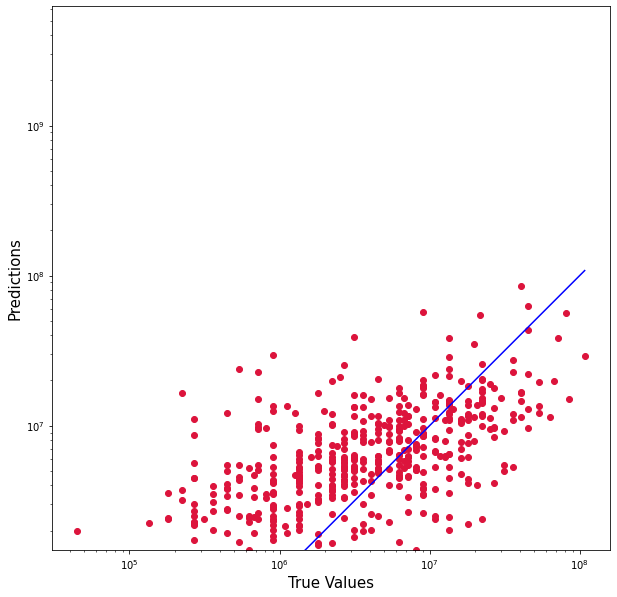

In [ ]:
draw_scatterplot(test_y, pred)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


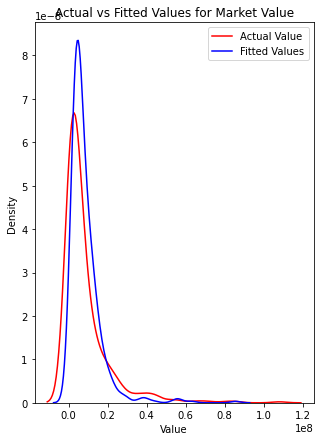

In [ ]:
draw_differences(test_y, pred)

In [ ]:
pred.shape

(480,)

In [ ]:
df = df_noshots
y = np.log(df['Value'])
#y = df['Value']
X = df.drop(columns='Value')
mse = 10

train_X, test_X, train_y, test_y = train_test_split(X, y,
                        test_size = 0.3, random_state = 123)
xgb_r = xg.XGBRegressor(objective ='reg:linear',
                    n_estimators = 100, seed = 123)
xgb_r.fit(train_X, train_y)
pred = xgb_r.predict(test_X)
print(mean_squared_error(test_y,pred))

[05:13:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
1.1674102541821327


In [ ]:
df = df_noshots
y = np.log(df['Value'])
#y = df['Value']
X = df.drop(columns='Value')
mse = 10

train_X, test_X, train_y, test_y = train_test_split(X, y,
                        test_size = 0.3, random_state = 123)
xgb_r = xg.XGBRegressor(objective ='reg:linear',
                    n_estimators = 100, seed = 123)
xgb_r.fit(train_X, train_y)
pred = xgb_r.predict(test_X)
print(mean_squared_error(test_y,pred))

[06:24:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
1.1674102541821327


In [ ]:
df = df_pca3
y = np.log(df['Value'])
#y = df['Value']
X = df.drop(columns='Value')
mse = 10

train_X, test_X, train_y, test_y = train_test_split(X, y,
                        test_size = 0.3, random_state = 123)
xgb_r = xg.XGBRegressor(objective ='reg:linear',
                    n_estimators = 100, seed = 123)
xgb_r.fit(train_X, train_y)
pred = xgb_r.predict(test_X)
print(mean_squared_error(test_y,pred))

[05:14:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
1.2353137568674128


In [ ]:
np.random.seed(123)

df = df_full
y = np.log(df['Value'])
X = df.drop(columns='Value')
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state=123)

params = {'max_depth': [int(x) for x in np.linspace(1, 10, num=2)],
          'min_child_weight': [int(x) for x in np.linspace(5, 10, num=1)],
          'max_delta_step': [int(x) for x in np.linspace(1, 10, num=1)],
          'n_estimators': [int(x) for x in np.linspace(start=500, stop= 2000, num=100)]}
xg_random = RandomizedSearchCV(
    estimator=xg.XGBRegressor(random_state=42),
                   param_distributions=params, cv=3,
                   scoring='neg_mean_squared_error', n_iter=20)
xg_random.fit(X_train, y_train)
print("Best parameters:", xg_random.best_params_)

[05:31:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:31:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:31:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:31:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:31:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:31:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:31:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:31:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

In [ ]:
y_pred = xg_random.predict(X_test)
mean_squared_error(y_test, y_pred)

1.2052802757553853